In [1]:
from collections import defaultdict
import csv
import glob
import json
import os
from PIL import Image
import re

import matplotlib.pyplot as plt
import numpy as np

### Analysis summary

In [7]:
"""Summarize metadata files for an experiment"""
rtype = 'uw_ensemble'
dataset = 'open100_10'
basedir = '/data/jongheon_jeong/dev/trl'

expdirs = glob.glob(f'{basedir}/save/{dataset}/{rtype}/b64_lr0.0003')
num_imgs_avg = 300

def subroutine(expdir):
    r_type = expdir.split('/')[-2]
    temp_dict = {}
    for ckpt_dir in glob.glob(f'{expdir}/checkpoints/checkpoint_*'):
        step = int(re.search('checkpoint_(\d+)', ckpt_dir).group(1))
        metadata_fn = f'{ckpt_dir}/inference.json'
        with open(metadata_fn, 'r') as f:
            data_dicts = json.load(f)
        for data_dict in sorted(data_dicts, key=lambda d: d['image']):
            image_name = data_dict['image']
            # ids = [int(id) for id in re.findall(r'\d+', image_name)]
            # if ids[1] > 1: continue  # Consider only seeds 0 and 1.
            for reward_type in [r_type]:
                if reward_type not in data_dict['rewards']: continue
                reward = data_dict['rewards'][reward_type]
                if image_name in temp_dict:
                    rewards_dict = temp_dict[image_name]['rewards']
                    if reward_type not in rewards_dict:
                        rewards_dict[reward_type] = {step: reward}
                    else:
                        rewards_dict[reward_type][step] = reward
                else:
                    rewards_dict = {'rewards': {reward_type: {step: reward}}}
                    temp_dict[image_name] = rewards_dict

    summary_dicts = []
    all_stats_dict = defaultdict(lambda: defaultdict(list))
    for image_name, temp_dict in temp_dict.items():
        sorted_reward_dict = defaultdict()
        for reward_name, reward_dict in temp_dict['rewards'].items():
            rewards = {}
            for step, reward in sorted(reward_dict.items()):
                rewards[step] = reward
                all_stats_dict[reward_name][step].append(reward)
            sorted_reward_dict[reward_name] = rewards
        summary_dict = {'image': image_name, 'rewards': sorted_reward_dict}
        summary_dicts.append(summary_dict)

    summary_entry = {'image': 'summary', 'rewards': {}}
    for reward_name, reward_dict in all_stats_dict.items():
        reward_mean_dict = {}
        for step, reward_list in reward_dict.items():
            reward_mean_dict[step] = np.mean(reward_list[:num_imgs_avg])
        summary_entry['rewards'][reward_name] = reward_mean_dict

    summary_dicts = [summary_entry] + summary_dicts
    with open(f'{expdir}/summary.json', 'w') as f:
        json.dump(summary_dicts, f, indent=4)


assert(expdirs)
for expdir in expdirs:
    subroutine(expdir)

['b64_lr0.0003']
b64_lr0.0003: ['0:0', '1:51', '2:52', '3:56', '4:55', '5:57', '6:60', '7:61', '8:62', '9:60', '10:62', '11:60', '12:56', '13:53', '14:56', '15:58', '16:56', '17:61', '18:60', '19:58', '20:58', '21:50', '22:57', '23:60', '24:60', '25:59', '26:56', '27:59', '28:57', '29:60', '30:58', '31:61', '32:64', '33:63', '34:66', '35:62', '36:63', '37:63', '38:65', '39:64', '40:68', '41:67', '42:66', '43:69', '44:69', '45:69', '46:71', '47:68', '48:69', '49:69', '50:66']


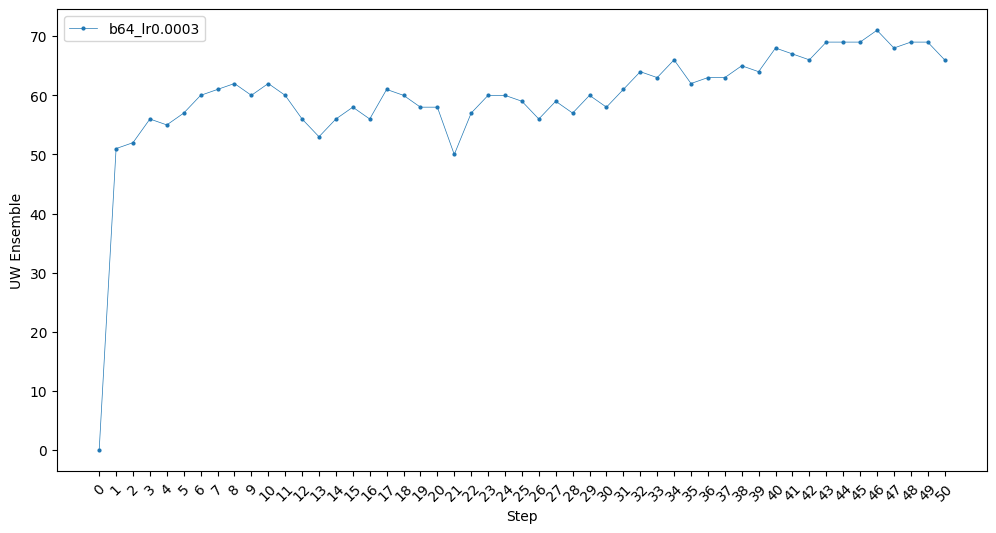

In [11]:
rtype = 'uw_ensemble'; dataset = 'open100_10'; selection = 'count'; num_imgs = 8; limit = 51
rlabel_dict = {'clip': 'CLIP', 'blip': 'BLIP', 'imagereward': 'ImageReward', 'pickscore': 'PickScore',
               'mean_ensemble': 'Mean Ensemble', 'uw_ensemble': 'UW Ensemble'}
basedir = f'/data/jongheon_jeong/dev/trl/save/{dataset}/{rtype}'
fname = 'summary.json'

summary_files = [f'{expdir}/{fname}' for expdir in glob.glob(f'{basedir}/*')]
dirnames = [fn.split('/')[-2] for fn in summary_files]
print(dirnames)
# labels = [dn[dn.find('lr'):dn.find('_', dn.find('es') or dn.find('kl'))] for dn in dirnames]
labels = [dn for dn in dirnames]
assert(len(summary_files) == len(labels))

all_summary_dicts = []
for summary_file in summary_files:
    with open(summary_file, 'r') as f:
        all_summary_dicts.append(json.load(f))

plt.figure(figsize=(12, 6))
for summary_dicts, label in zip(all_summary_dicts, labels):
    the_summary_dict, other_summary_dicts = summary_dicts[0], summary_dicts[1:]
    the_reward_dict = the_summary_dict['rewards'][rtype]
    x_values = list(the_reward_dict.keys())
    assert(the_summary_dict['image'] == 'summary')
    if selection == 'average':
        y_values = np.array(list(the_reward_dict.values()))
    elif selection == 'count':
        y_values = [sum(s_dict['rewards'][rtype][step] > s_dict['rewards'][rtype]['0']
                        for s_dict in other_summary_dicts
                        if int(re.findall(r'\d+', s_dict['image'])[2]) < num_imgs)
                    for step in x_values]
    else:
        raise ValueError(f'Unsupported selection type: {selection}')
    x_values, y_values = x_values[:limit], y_values[:limit]
    print(f'{label}: {[f"{x}:{y}" for x, y in zip(x_values, y_values)]}')
    plt.plot(x_values, y_values, 'o-',
             linewidth=0.5, markersize=2, label=label)
plt.xlabel('Step'); plt.xticks(rotation=45); plt.ylabel(rlabel_dict[rtype])
plt.legend()
plt.show()

### Eval prep

In [14]:
# Create merged images generated using fine-tuned models.
dataset = 'open100_10'; rtype = 'uw_ensemble'; ckpt = 'b64_lr0.0003/checkpoints/checkpoint_46'
nimgs = 4; q_per_p = 2

ckptdir = f'/data/jongheon_jeong/dev/trl/save/{dataset}/{rtype}/{ckpt}'; imgdir = f'{ckptdir}/images'
outdir = f'{ckptdir}/mturk'
if not os.path.exists(outdir): os.makedirs(outdir)

p_to_dicts = defaultdict(list)
with open(f'{ckptdir}/inference.json', 'r') as f:
    for data_dict in json.load(f):
        p_to_dicts[data_dict['caption']].append(data_dict)

csv_rows = []
for prompt, data_dicts in p_to_dicts.items():
    all_imgs = [d['image'] for d in data_dicts]
    for qidx in range(q_per_p):
        imgs = all_imgs[qidx * nimgs:(qidx + 1) * nimgs]
        pil_imgs = [Image.open(f'{imgdir}/{img}') for img in imgs]
        img_size = pil_imgs[0].size  # Assume the images are of the same size.
        new_img = Image.new(mode='RGB', size=(len(pil_imgs) * img_size[0], img_size[1]))
        for idx, pil_img in enumerate(pil_imgs):
            new_img.paste(pil_img, (idx * img_size[0], 0))
        # new_img.show(); print(p_to_stype_to_scores[prompt][stype])

        prefix = re.findall('image_\d+', imgs[0])[0]
        suffixes = '-'.join(['_'.join(re.findall(r'\d+', img)[1:]) for img in imgs])
        new_img_fn = f'{prefix}-{suffixes}-{qidx}.jpg'
        new_img.save(f'{outdir}/{new_img_fn}')
        csv_rows.append({'prompt': prompt, 'img_path': new_img_fn})

with open(f'{outdir}/data.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['prompt', 'img_path'])
    writer.writeheader()
    for csv_row in csv_rows:
        writer.writerow(csv_row)